In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import copy
import datetime

In [2]:
nrows = 500
ncols = 6

np.random.seed(27)
series = pd.Series(np.random.weibull(7,nrows) * 100, index=pd.date_range(start='2021-12-01 00:00:00', periods=nrows), name='process A')
frame = pd.DataFrame(np.random.normal(loc=100, scale=20, size=ncols*nrows).reshape(nrows, ncols), index=pd.date_range(start='1-1-2020', periods=nrows), columns=[f'process {col}' for col in range(1, ncols+1)])

In [57]:
def iso(_obj, **kwargs):
    '''
    change the pandas.DatetimeIndex to a IsoDatetimeMultiIndex
    '''

    if isinstance(_obj, pd.MultiIndex):
        return _obj

    elif isinstance(_obj, pd.DatetimeIndex):

        levels = ['year','week','day']
        level = kwargs.get('level', levels[-1])

        # get the levels
        if isinstance(level, str) and level in levels:
            levels = levels[:levels.index(level)+1]
        elif isinstance(level, list):
            _levels = [l for l in level if l in levels]
            if len(_levels) > 0:
                levels = _levels

        frame = _obj.isocalendar()[levels]

        return pd.MultiIndex.from_frame(frame[levels])

In [59]:
s0 = pd.Series(index=iso(series.index), data=series.values)

In [171]:
def get_year_ticks(obj, max_ticks=17):
    
    if max_ticks is not None:
        rng = obj.index.isocalendar().year.unique().size
        _group = np.ceil(rng/max_ticks)
        _groups = np.array([1, 4, 13, 26, 52])
        group = _groups[np.greater_equal(_groups - _group, 0).argmax()]
    else:
        group = 1
        
    ticks = []
    years = obj.index.isocalendar().year.unique()
    if group > 1:
        years = years[np.where(np.mod(years, group)==1)]
        
    for year in years:#obj.index.isocalendar().year.unique():
        ticks.append(matplotlib.dates.date2num(datetime.datetime.fromisocalendar(year, 1, 1)))
            
    return ticks

In [173]:
def get_week_ticks(obj, max_ticks=17):
    
    if max_ticks is not None:
        rng = obj.index.isocalendar()[['year', 'week']].apply(tuple, axis=1).unique().size
        _group = np.ceil(rng/max_ticks)
        _groups = np.array([1, 4, 13, 26, 52])
        group = _groups[np.greater_equal(_groups - _group, 0).argmax()]
    else:
        group = 1
    
    ticks = []
    for year in obj.index.isocalendar().year.unique():
        weeks = obj[obj.index.isocalendar().year==year].index.isocalendar().week.to_numpy()
        if group > 1:
            weeks = weeks[np.where(np.mod(weeks, group)==1)]
        for week in weeks:
            ticks.append(matplotlib.dates.date2num(datetime.datetime.fromisocalendar(year, week, 1)))
            
    return ticks

In [242]:
def get_max_ticks(ax, ratio=0.75):
    
    # get ax width in pixels
    ax_width = ax.figure.get_figwidth() * (ax.figure.subplotpars.right - ax.figure.subplotpars.left) * ax.figure.dpi
    
    # get text width: tick label font size * 2 characters * .75 width ratio
    label_width = ax.xaxis.get_majorticklabels()[0].get_fontsize() * 2 * ratio
    
    return np.floor(ax_width / label_width)

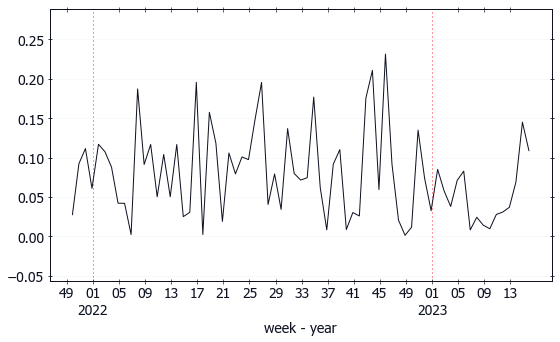

In [244]:
# prepare figure
fig, ax = plt.subplots(figsize=(9,5), nrows=1, ncols=1)
ax.plot(q)
# ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1,interval=2))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%V'))
ax.tick_params(axis='x', which='both')

max_ticks = get_max_ticks(ax)
major_ticks = get_year_ticks(q, max_ticks=max_ticks)
minor_ticks = get_week_ticks(q, max_ticks=max_ticks)

locator_major = matplotlib.ticker.FixedLocator(major_ticks)
formatter_major = matplotlib.dates.DateFormatter('%V\n%G')
ax.xaxis.set_major_locator(locator_major)
ax.xaxis.set_major_formatter(formatter_major)

locator_minor = matplotlib.ticker.FixedLocator(minor_ticks)
formatter_minor = matplotlib.dates.DateFormatter('%V')

ax.xaxis.set_minor_locator(locator_minor)
ax.xaxis.set_minor_formatter(formatter_minor)

ax.tick_params(axis='x', which='minor', length=5, width=0.6, color='black', top=True)
ax.tick_params(axis='x', which='major', length=5, width=0.6, color='black', top=False, grid_color='red', grid_linewidth=1, grid_linestyle='dotted', grid_alpha=0.5, direction='inout')

ax.set_xlabel('week - year')
plt.show()

In [49]:
# het orginele object is gewoon te benaderen
# groupby helemaal herschrijven
# en misschien resample er naast?
# of alleen resample?

# wat doe ik dan met de index? bij plotten: andere opties om het mooi te maken?

series.resample('W').obj

2021-12-01     91.924281
2021-12-02    107.740009
2021-12-03    104.152804
2021-12-04    110.604887
2021-12-05     90.139313
                 ...    
2022-05-25     74.725901
2022-05-26     96.032828
2022-05-27     96.242706
2022-05-28    116.345326
2022-05-29     98.568934
Freq: D, Name: process A, Length: 180, dtype: float64

In [57]:
series.apply(lambda x: type(x).__name__)

2022-01-01    float
2022-01-02    float
2022-01-03    float
2022-01-04    float
2022-01-05    float
              ...  
2022-06-25    float
2022-06-26    float
2022-06-27    float
2022-06-28    float
2022-06-29    float
Freq: D, Name: process A, Length: 180, dtype: object